<a href="https://colab.research.google.com/github/YashK07/Generative-AI/blob/master/DCGANs_for_fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get Started: DCGAN for Fashion-MNIST
Author: Margaret Maynard-Reid ([@margaretmz](https://twitter.com/margaretmz))

This Colab notebook is a DCGAN implementation with TensorFlow 2 / Keras, trained with Fashion-MNIST to generates gray-scale 28x28x1 images. Link to the DCGAN Paper: [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434).

It is associated with the [Get Started: DCGAN for Fashion-MNIST](https://www.pyimagesearch.com/2021/11/11/get-started-dcgan-for-fashion-mnist/) blog post published on 2021-11-11, as part of the [PyImageSearch University](https://www.pyimagesearch.com/pyimagesearch-university/) GAN series. 

You may find all the GANs Colab notebooks in the GitHub repo [here](https://github.com/margaretmz/GANs-in-Art-and-Design).

Here are some helpful resources in case if you are unfamiliar with Jupyter notebooks or Colab:
*   [Jupyter Notebook User Interface](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface)
*   [Overview of Google Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)
  
---  
  
**Copyright:**  
Please note the code is licensed as [Creative Commons Attribution-NonCommercial 4.0](https://creativecommons.org/licenses/by-nc/4.0/) which means you are free to share and adapt the code, under the condition that you give appropriate credit to the author and you may not use it for commercial purposes.



Table of Contents

>[Get Started: DCGAN for Fashion-MNIST](#scrollTo=wxWgWoUYNNYe)

>>[Imports](#scrollTo=wcrOk6pURp50)

>>[Prepare Fashion-MNIST data](#scrollTo=mu11hf0_rqRq)

>>>[Loading](#scrollTo=fswXPGriDWZa)

>>>[Visualization](#scrollTo=PFE71AWEDZBp)

>>>[Preprocessing](#scrollTo=Eo818wWbDY7S)

>>[The generator model](#scrollTo=BY-sz-IFbWr7)

>>[The discriminator model](#scrollTo=9qAUg0qNbXpS)

>>[Define DCGAN class: override train_step](#scrollTo=urgSpXaPQlKk)

>>[Use Keras Callback to monitor training](#scrollTo=QtlnNc4lQw53)

>>[Train the DCGAN model](#scrollTo=9OubidSS_Lrl)



## Imports

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt

Its always a good practice to check the current version of TensorFlow...

In [2]:
print(tf.version.VERSION)

2.12.0


## Prepare Fashion-MNIST data
The first step is to get data ready for training.


In [3]:
# load the Fashion MNIST dataset and it's OK to use just the training data
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


There are 60,000 training gray scale images in Fashion-MNIST.

In [4]:
train_images.shape

(60000, 28, 28)

In [5]:
type(train_images)

numpy.ndarray

### Visualization

I always like to visualize the training data to get an idea of what the images look like. 

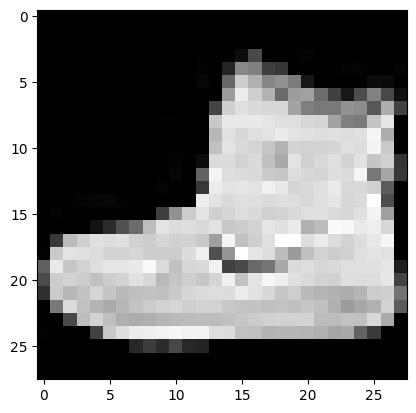

In [6]:
plt.figure()
plt.imshow(train_images[0], cmap='gray')
plt.show()

### Preprocessing

In [7]:
# Reshape data and also convert the data type to 'float32'
print(train_images.shape)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
print(train_images.shape)

# Normalize the images to [-1, 1] which is the range of the tanh activation
train_images = (train_images - 127.5) / 127.5  

(60000, 28, 28)
(60000, 28, 28, 1)


Since the input images are normalized in the range of -1 to 1. The last layer activation as tanh (-1,1) would be an appropriate choice. 

## The generator model

Define the generator model architecture with the Keras `Sequential` API.

Use `ReLU` except for the last layer which has `tanh` as the activation.

The job of the generator is to make images, to do so in DCGAN, we feed random noise as input to the generator and upsample till the desired image size becomes 28x28x1.

In [8]:
# latent dimension of the random noise
LATENT_DIM = 100 
# weight initializer for G per DCGAN paper
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02) 
# number of channels, 1 for gray scale and 3 for color images
CHANNELS = 1

In [9]:
def build_generator():
    # create a Keras Sequential model 
    model = Sequential(name="generator")

    # prepare for reshape: FC => BN => RN layers, note: input shape defined in the 1st Dense layer  
    model.add(layers.Dense(7 * 7 * 256, input_dim=LATENT_DIM))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # 1D => 3D: reshape the output of the previous layer 
    model.add(layers.Reshape((7, 7, 256)))

    # upsample to 14x14: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # upsample to 28x28: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # final layer: Conv2D with tanh activation
    model.add(layers.Conv2D(CHANNELS, (5, 5), padding="same", activation="tanh"))

    # return the generator model
    return model

In [10]:
# build the generator model
generator = build_generator() 

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [11]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1266944   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      819328    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 128)      51

## The discriminator model

Define the discriminator model architecture with the Keras `Sequential` API

In [12]:
def build_discriminator(width, height, depth, alpha=0.2):
    # create a Keras Sequential model
    model = Sequential(name="discriminator")
    input_shape = (height, width, depth)

    # first set of CONV => BN => leaky ReLU layers
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", 
        input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # second set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # flatten and apply dropout
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))

    # sigmoid in the last layer outputs a single value for binary classification
    model.add(layers.Dense(1, activation="sigmoid"))

    # return the discriminator model
    return model

In [13]:
# build the discriminator model
discriminator = build_discriminator(28, 28, 1) 

In [14]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)       

## Define `DCGAN` class: override `train_step`
Subclass `keras.Model` and override `train_step` to implement the DCGAN architecture. This is where the magic happens and the heart of the DCGAN implementation. 

**The discriminator loss** includes both the loss from the real images and the loss from the fake images.  
**The generator loss** is calculated with thefake images.


In [15]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Step 1. Train the discriminator with both real images (label as 1) and fake images (classified as label as 0) 
        with tf.GradientTape() as tape:
            # Compute discriminator loss on real images
            pred_real = self.discriminator(real_images, training=True)
            d_loss_real = self.loss_fn(tf.ones((batch_size, 1)), pred_real)

            # Compute discriminator loss on fake images
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            d_loss_fake = self.loss_fn(tf.zeros((batch_size, 1)), pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake)/2
        # Compute discriminator gradients
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Update discriminator weights
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Step 2. Train the generator (do not update weights of the discriminator)
        # G wants D to think the fake images are real (label as 1)
        misleading_labels = tf.ones((batch_size, 1)) 

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator weights
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

## Use Keras `Callback` to monitor training

The nice thing about overriding `train_step` of `keras.Model` is that we can subclass `Callback` to monitor our DCGAN training.

I use the seed noise to create images (with the generator model) throughout the training to visually inspect the progress of the generator. You can also save the generator model at the end of the training which could potentially be used for inference later.

In [16]:
#callback
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

        # Create random noise seed for visualization during training
        self.seed = tf.random.normal([16, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        # random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        # generated_images = self.model.generator(random_latent_vectors)
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(4, 4))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(generated_images[i]) 
            plt.imshow(img, cmap='gray')
            plt.axis('off')
        plt.savefig('epoch_{:03d}.png'.format(epoch)) 
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

## Train the DCGAN model

Compile the `dcgan` model, with the `Adam` optimizer, learning rate of 0.0002, and the **Binary Cross Entropy** loss functionas recommended by the paper. In future GAN tutorials, you will learn other loss functions for other GAN variants.

Putting together the `dcgan` model.

In [17]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)

Compile the `dcgan` model.

In [18]:
LR = 0.0002 # learning rate

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=LR, beta_1 = 0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

Now we simply call `model.fit()` to traing the `dcgan` model!

Epoch 1/50
   5/1875 [..............................] - ETA: 59s - d_loss: 0.6443 - g_loss: 1.2881

1875/1875 [==============================] - ETA: 0s - d_loss: 0.2694 - g_loss: 1.4906

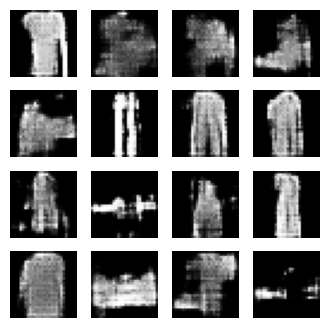

1875/1875 [==============================] - 51s 19ms/step - d_loss: 0.2694 - g_loss: 1.4906
Epoch 2/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6306 - g_loss: 0.9587

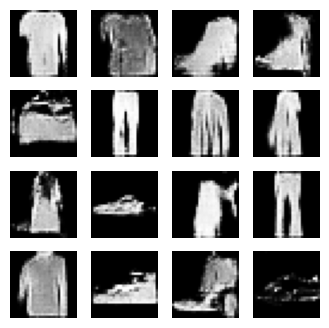

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6305 - g_loss: 0.9586
Epoch 3/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6497 - g_loss: 0.9304

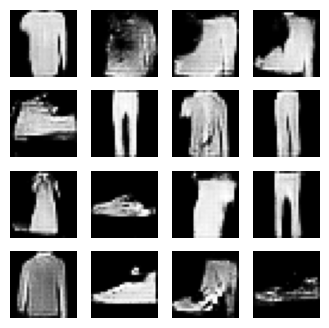

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6498 - g_loss: 0.9305
Epoch 4/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6577 - g_loss: 0.8814

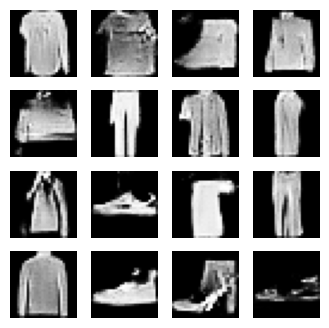

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6577 - g_loss: 0.8814
Epoch 5/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6670 - g_loss: 0.8578

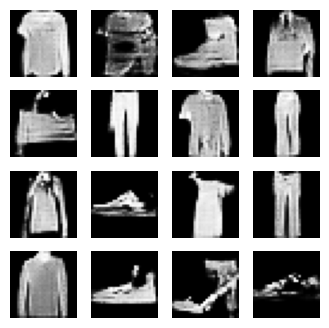

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6670 - g_loss: 0.8578
Epoch 6/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6685 - g_loss: 0.8393

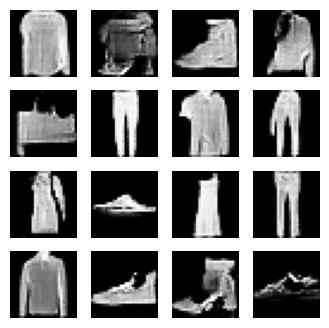

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6685 - g_loss: 0.8395
Epoch 7/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6690 - g_loss: 0.8377

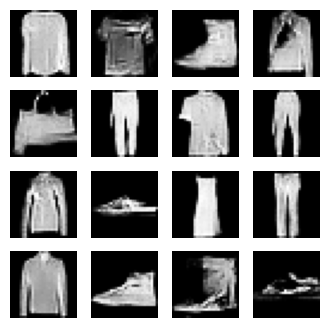

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6690 - g_loss: 0.8378
Epoch 8/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6696 - g_loss: 0.8259

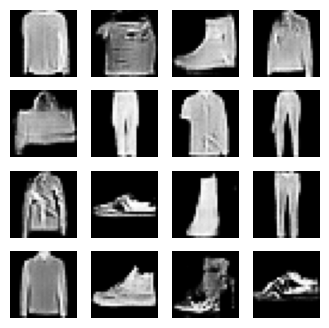

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6696 - g_loss: 0.8260
Epoch 9/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6705 - g_loss: 0.8204

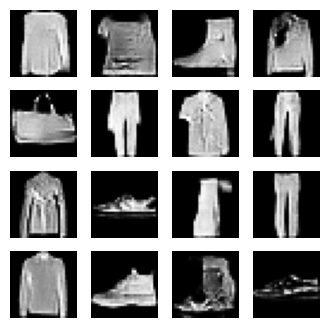

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6705 - g_loss: 0.8204
Epoch 10/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6704 - g_loss: 0.8152

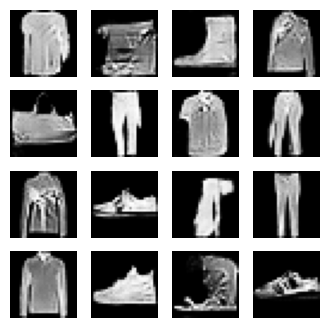

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6704 - g_loss: 0.8152
Epoch 11/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6718 - g_loss: 0.8169

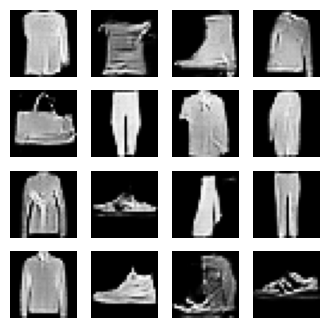

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6718 - g_loss: 0.8169
Epoch 12/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6733 - g_loss: 0.8115

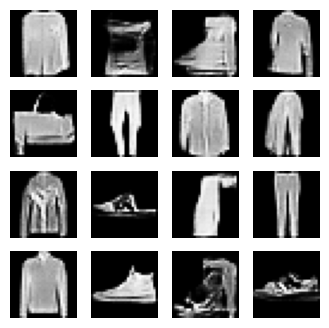

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6733 - g_loss: 0.8115
Epoch 13/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6724 - g_loss: 0.8108

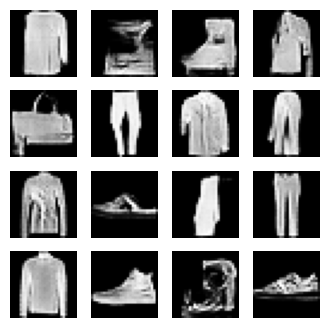

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6724 - g_loss: 0.8108
Epoch 14/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6738 - g_loss: 0.8085

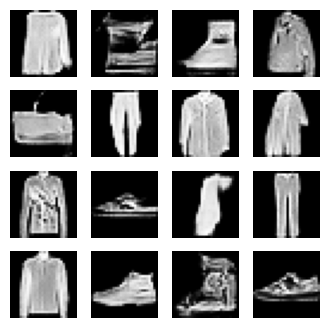

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6738 - g_loss: 0.8085
Epoch 15/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6708 - g_loss: 0.8049

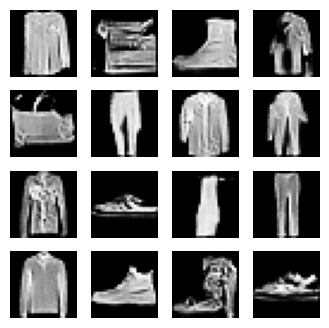

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6708 - g_loss: 0.8049
Epoch 16/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6720 - g_loss: 0.8090

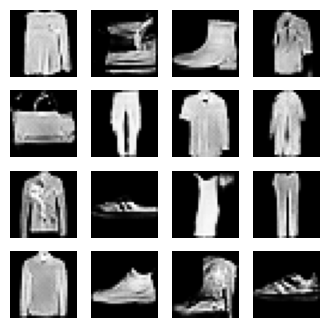

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6720 - g_loss: 0.8091
Epoch 17/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6715 - g_loss: 0.8075

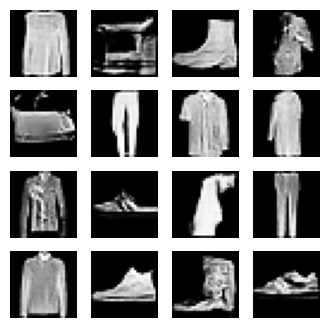

1875/1875 [==============================] - 38s 20ms/step - d_loss: 0.6715 - g_loss: 0.8075
Epoch 18/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6723 - g_loss: 0.7984

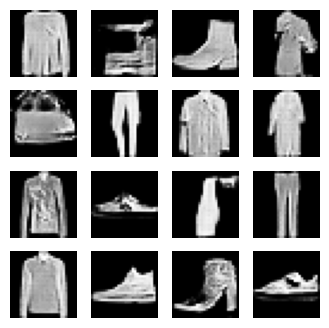

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6723 - g_loss: 0.7983
Epoch 19/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6718 - g_loss: 0.8028

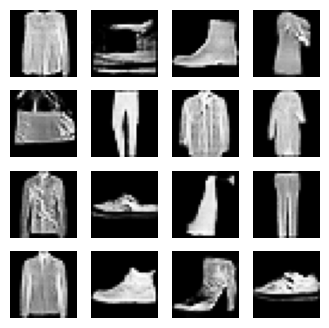

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6718 - g_loss: 0.8028
Epoch 20/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6725 - g_loss: 0.8034

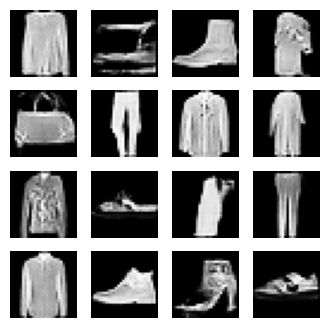

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6725 - g_loss: 0.8034
Epoch 21/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6731 - g_loss: 0.8017

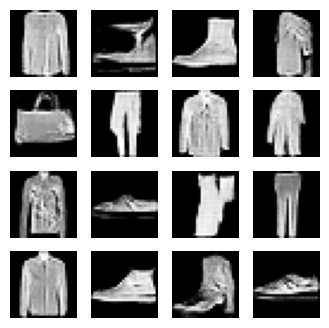

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6731 - g_loss: 0.8016
Epoch 22/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6725 - g_loss: 0.8011

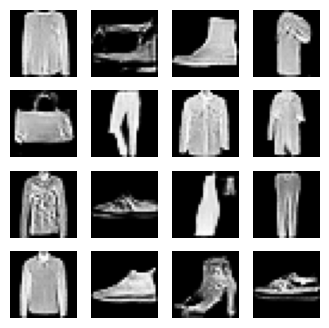

1875/1875 [==============================] - 38s 20ms/step - d_loss: 0.6725 - g_loss: 0.8011
Epoch 23/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6720 - g_loss: 0.8012

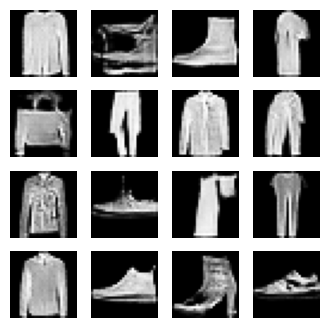

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6721 - g_loss: 0.8012
Epoch 24/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6708 - g_loss: 0.7974

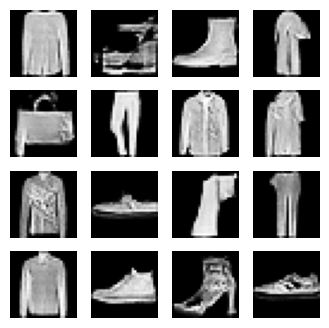

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6708 - g_loss: 0.7974
Epoch 25/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6721 - g_loss: 0.7984

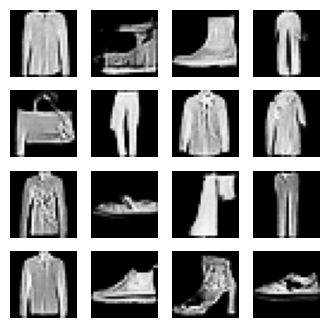

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6721 - g_loss: 0.7983
Epoch 26/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6730 - g_loss: 0.7982

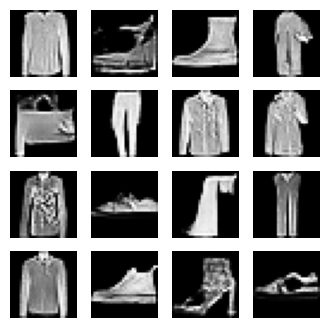

1875/1875 [==============================] - 38s 20ms/step - d_loss: 0.6731 - g_loss: 0.7982
Epoch 27/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6725 - g_loss: 0.7967

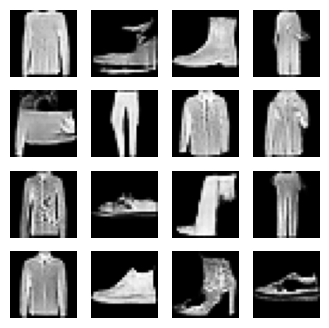

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6725 - g_loss: 0.7967
Epoch 28/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6710 - g_loss: 0.7990

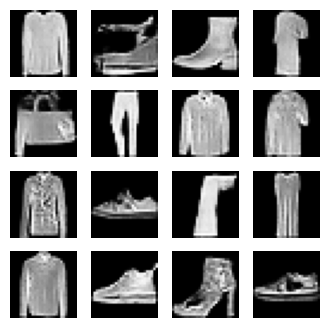

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6710 - g_loss: 0.7990
Epoch 29/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6703 - g_loss: 0.7989

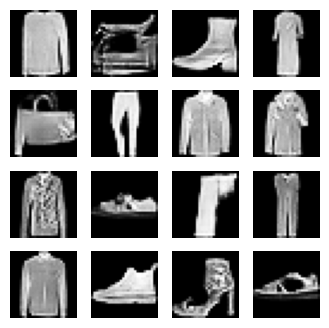

1875/1875 [==============================] - 38s 20ms/step - d_loss: 0.6703 - g_loss: 0.7988
Epoch 30/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6708 - g_loss: 0.8017

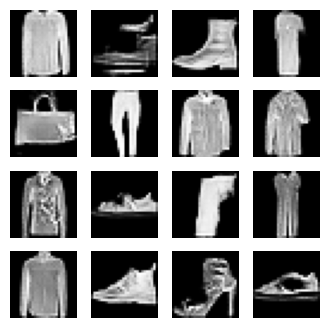

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6708 - g_loss: 0.8017
Epoch 31/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6729 - g_loss: 0.8023

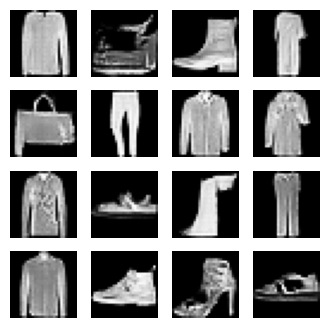

1875/1875 [==============================] - 38s 20ms/step - d_loss: 0.6729 - g_loss: 0.8023
Epoch 32/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6704 - g_loss: 0.8012

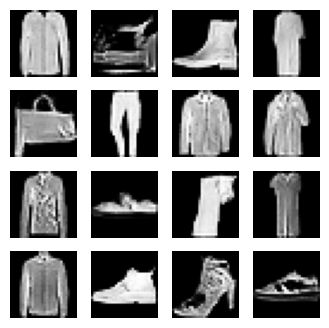

1875/1875 [==============================] - 38s 20ms/step - d_loss: 0.6703 - g_loss: 0.8012
Epoch 33/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6719 - g_loss: 0.7997

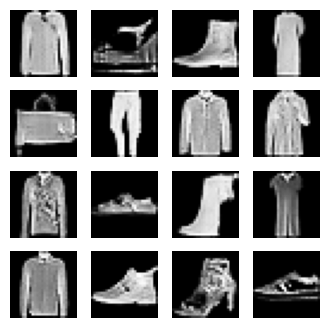

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6718 - g_loss: 0.7998
Epoch 34/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6710 - g_loss: 0.7980

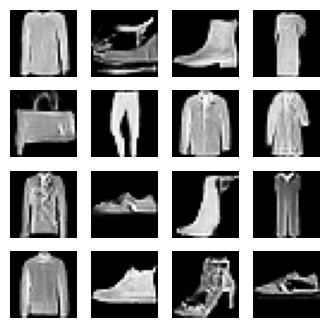

1875/1875 [==============================] - 42s 22ms/step - d_loss: 0.6710 - g_loss: 0.7980
Epoch 35/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6709 - g_loss: 0.7962

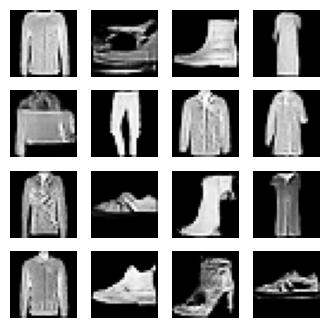

1875/1875 [==============================] - 38s 20ms/step - d_loss: 0.6709 - g_loss: 0.7962
Epoch 36/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6703 - g_loss: 0.8010

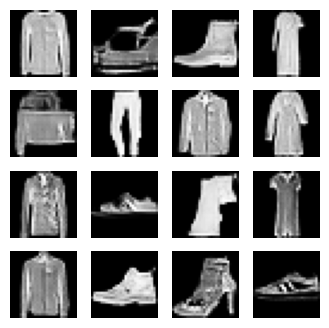

1875/1875 [==============================] - 38s 20ms/step - d_loss: 0.6703 - g_loss: 0.8010
Epoch 37/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6698 - g_loss: 0.7997

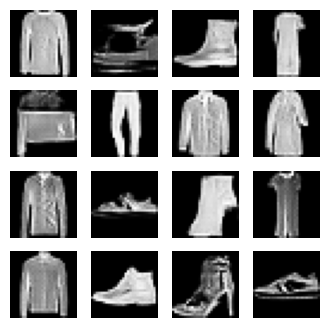

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6698 - g_loss: 0.7997
Epoch 38/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6706 - g_loss: 0.8051

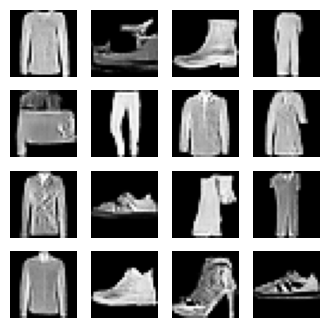

1875/1875 [==============================] - 38s 20ms/step - d_loss: 0.6706 - g_loss: 0.8051
Epoch 39/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6695 - g_loss: 0.8046

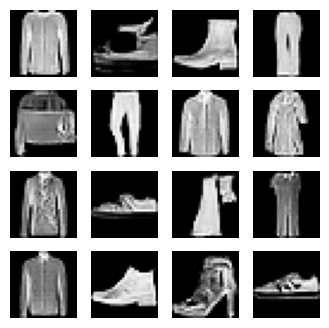

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6695 - g_loss: 0.8046
Epoch 40/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6697 - g_loss: 0.8033

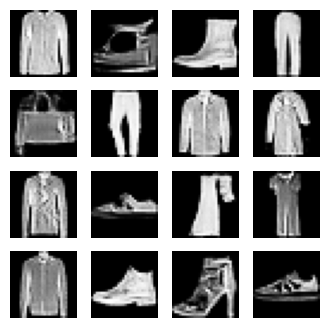

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6697 - g_loss: 0.8033
Epoch 41/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6698 - g_loss: 0.8027

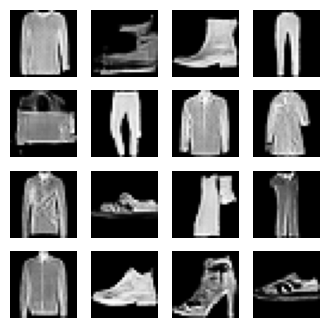

1875/1875 [==============================] - 38s 20ms/step - d_loss: 0.6698 - g_loss: 0.8027
Epoch 42/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6701 - g_loss: 0.8020

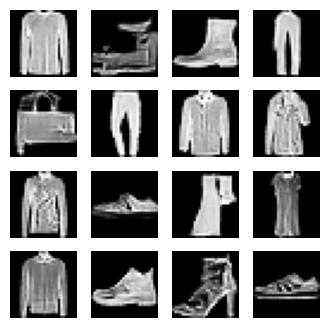

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6701 - g_loss: 0.8020
Epoch 43/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6683 - g_loss: 0.8036

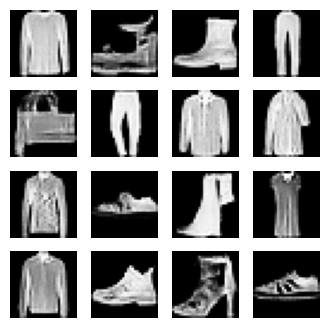

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6683 - g_loss: 0.8037
Epoch 44/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6690 - g_loss: 0.8048

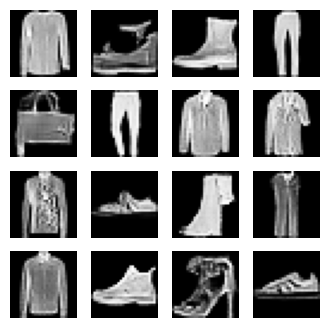

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6690 - g_loss: 0.8048
Epoch 45/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6688 - g_loss: 0.8035

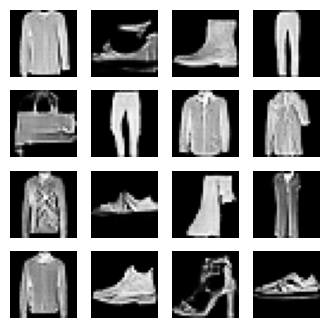

1875/1875 [==============================] - 38s 20ms/step - d_loss: 0.6688 - g_loss: 0.8034
Epoch 46/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6689 - g_loss: 0.8039

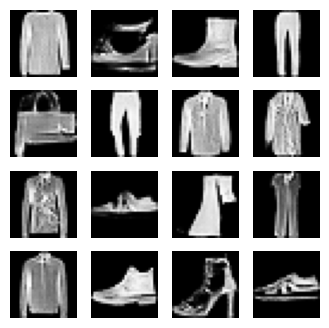

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6689 - g_loss: 0.8039
Epoch 47/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6676 - g_loss: 0.8021

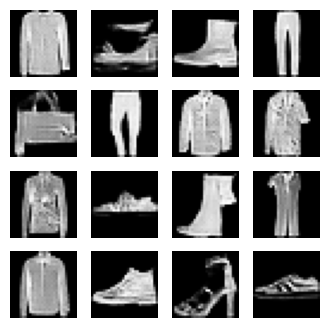

1875/1875 [==============================] - 38s 20ms/step - d_loss: 0.6675 - g_loss: 0.8022
Epoch 48/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6689 - g_loss: 0.8061

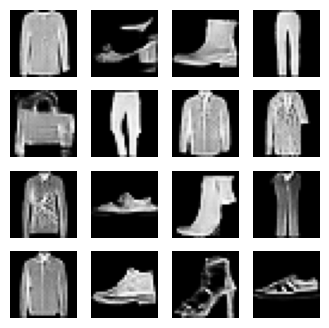

1875/1875 [==============================] - 38s 20ms/step - d_loss: 0.6689 - g_loss: 0.8061
Epoch 49/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6678 - g_loss: 0.8048

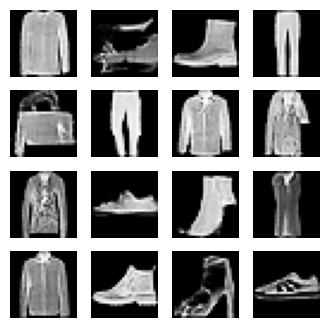

1875/1875 [==============================] - 38s 20ms/step - d_loss: 0.6678 - g_loss: 0.8048
Epoch 50/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6665 - g_loss: 0.8057

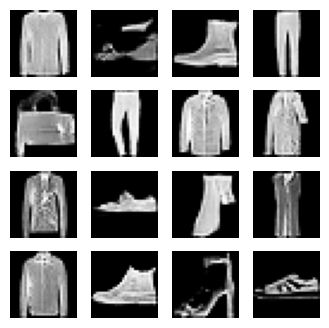

1875/1875 [==============================] - 38s 20ms/step - d_loss: 0.6665 - g_loss: 0.8056


In [19]:
NUM_EPOCHS = 50 # number of epochs
dcgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])